In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


Import libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model

import transformers
from transformers import BertTokenizer, TFBertModel

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [105]:
df = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding="ISO-8859-1")

In [106]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [107]:
df.drop(['Unnamed: 2', 'Unnamed: 3' ,'Unnamed: 4'], axis=1,inplace=True)

In [108]:
df.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)

In [109]:
df['Class'] = df['Class'].map({'ham':0, 'spam':1})
df.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [110]:
# Now we can see this is imbalanced target 
df['Class'].value_counts()

0    4825
1     747
Name: Class, dtype: int64

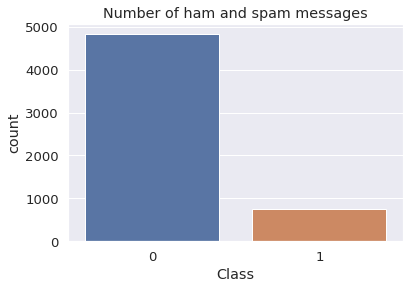

In [111]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.Class).set_title("Number of ham and spam messages")
plt.show()

In [112]:
df['length'] = df.Text.apply(len)
df.head()

,Class,Text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


Now lets see the SMS length and target relationship

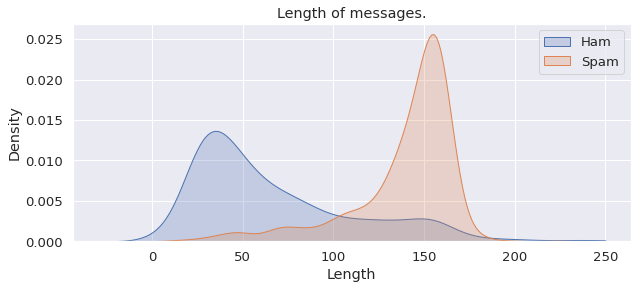

In [113]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.Class == 0, "length"], shade=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(df.loc[df.Class == 1, "length"], shade=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()

Text preprocessing and cleaning 

In [114]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


Functions for data cleaning

In [115]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [116]:
df['Text'] = df['Text'].apply(clean_text)
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(stemmer)

In [117]:
df.head()

,Class,Text,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


In [118]:
X = df['Text']
y = df['Class']

In [119]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [120]:
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

train, test = train_test_split(df.rename(columns={"Text":"Text", "Class":"labels"}), test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
trainh = Dataset.from_pandas(train)
testh = Dataset.from_pandas(test)
valh = Dataset.from_pandas(val)


ds = DatasetDict()

ds['train'] = trainh
ds['test'] = testh
ds['validation'] = valh

print(ds)

DatasetDict({
    train: Dataset({
        features: ['labels', 'Text', 'length', '__index_level_0__'],
        num_rows: 3565
    })
    test: Dataset({
        features: ['labels', 'Text', 'length', '__index_level_0__'],
        num_rows: 1115
    })
    validation: Dataset({
        features: ['labels', 'Text', 'length', '__index_level_0__'],
        num_rows: 892
    })
})


## BERT Base

In [121]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer

In [122]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

The function which allows to encode our dataset with BERT tokenizer, maximum sentence length is 64 (maxlen).

In [123]:
# def encode(text, maxlen):
#     input_ids=[]
#     attention_masks=[]

#     for row in text:
#         encoded = tokenizer.encode_plus(
#             row,
#             add_special_tokens=True,
#             max_length=maxlen,
#             pad_to_max_length=True,
#             return_attention_mask=True,
#         )
#         input_ids.append(encoded['input_ids'])
#         attention_masks.append(encoded['attention_mask'])

#     return np.array(input_ids),np.array(attention_masks)

In [124]:
# X_train_input_ids, X_train_attention_masks = encode(X_train.values, maxlen=64)
# X_test_input_ids, X_test_attention_masks = encode(X_test.values, maxlen=64)

In [125]:
# def build_model(bert_model):
#     input_word_ids = tf.keras.Input(shape=(64,),dtype='int32')
#     attention_masks = tf.keras.Input(shape=(64,),dtype='int32')

#     sequence_output = bert_model([input_word_ids,attention_masks])
#     output = sequence_output[1]
#     output = tf.keras.layers.Dense(32,activation='relu')(output)
#     output = tf.keras.layers.Dropout(0.2)(output)
#     output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

#     model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
#     model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

#     return model

In [126]:
# model = build_model(bert_model)
# model.summary()

In [127]:
# class_weight = {0: 1, 1: 8}

In [128]:
# history = model.fit(
#     [X_train_input_ids, X_train_attention_masks],
#     y_train,
#     batch_size=32,
#     epochs=5,
#     validation_data=([X_test_input_ids, X_test_attention_masks], y_test),
#     class_weight=class_weight)

In [129]:
# def plot_graphs(history, string):
#     plt.plot(history.history[string])
#     plt.plot(history.history['val_'+string])
#     plt.xlabel("Epochs")
#     plt.ylabel(string)
#     plt.legend([string, 'val_'+string])
#     plt.show()

In [130]:
# loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], y_test)
# print('Test accuracy :', accuracy)

In [131]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)


tokenized_datasets = ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [132]:
from transformers import TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments("test-trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [133]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

In [134]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [135]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [136]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3565
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1338


Step,Training Loss
500,0.146200
1000,0.041200


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1338, training_loss=0.0737930612891957, metrics={'train_runtime': 95.2148, 'train_samples_per_second': 112.325, 'train_steps_per_second': 14.052, 'total_flos': 161677118519700.0, 'train_loss': 0.0737930612891957, 'epoch': 3.0})

In [137]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1115
  Batch size = 8


(1115, 2) (1115,)


In [138]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)

In [139]:
from sklearn.metrics import accuracy_score
x = accuracy_score(preds, y_test)
print(x)

0.7650224215246637


## BERT Large

In [140]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)


tokenized_datasets = ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file https://huggingface.co/bert-large-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1cf090f220f9674b67b3434decfe4d40a6532d7849653eac435ff94d31a4904c.1d03e5e4fa2db2532c517b2cd98290d8444b237619bd3d2039850a6d5e86473d
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-large-uncased/resolv

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [141]:
from transformers import TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments("test-trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [142]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

loading configuration file https://huggingface.co/bert-large-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1cf090f220f9674b67b3434decfe4d40a6532d7849653eac435ff94d31a4904c.1d03e5e4fa2db2532c517b2cd98290d8444b237619bd3d2039850a6d5e86473d
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-large-uncase

In [143]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [144]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [145]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3565
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1338


Step,Training Loss
500,0.321400
1000,0.404800


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1338, training_loss=0.3774566650390625, metrics={'train_runtime': 290.6004, 'train_samples_per_second': 36.803, 'train_steps_per_second': 4.604, 'total_flos': 572655441159060.0, 'train_loss': 0.3774566650390625, 'epoch': 3.0})

In [146]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1115
  Batch size = 8


(1115, 2) (1115,)


In [147]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)

In [148]:
from sklearn.metrics import accuracy_score
x = accuracy_score(preds, y_test)
print(x)

0.8511210762331839


## BERT Medium

In [149]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)


tokenized_datasets = ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file https://huggingface.co/bert-large-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1cf090f220f9674b67b3434decfe4d40a6532d7849653eac435ff94d31a4904c.1d03e5e4fa2db2532c517b2cd98290d8444b237619bd3d2039850a6d5e86473d
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-large-uncased/resolv

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [150]:
from transformers import TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments("test-trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [151]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-medium", num_labels=2)

loading configuration file https://huggingface.co/prajjwal1/bert-medium/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/288b0ee1e79a7c3fe770ab8a84ece013c573e7d226ccb5d9ffad317b3419faac.4344f82f77799c092b30b2e0d3749c809f82df14c5993e43dbbdc52f5a0d86e0
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-medium",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-medium/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/trans

In [152]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [153]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [154]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3565
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1338


Step,Training Loss
500,0.127000
1000,0.044000


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1338, training_loss=0.0697315911719261, metrics={'train_runtime': 60.643, 'train_samples_per_second': 176.36, 'train_steps_per_second': 22.064, 'total_flos': 48105472892820.0, 'train_loss': 0.0697315911719261, 'epoch': 3.0})

In [155]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1115
  Batch size = 8


(1115, 2) (1115,)


In [156]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)

In [157]:
from sklearn.metrics import accuracy_score
x = accuracy_score(preds, y_test)
print(x)

0.7650224215246637


## BERT Small

In [158]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "prajjwal1/bert-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)


tokenized_datasets = ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert

  0%|          | 0/4 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [159]:
from transformers import TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments("test-trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [160]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-small/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transfor

In [161]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [162]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [163]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3565
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1338


Step,Training Loss
500,0.129200
1000,0.048600


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1338, training_loss=0.07344105781817471, metrics={'train_runtime': 34.7419, 'train_samples_per_second': 307.841, 'train_steps_per_second': 38.513, 'total_flos': 24302577880980.0, 'train_loss': 0.07344105781817471, 'epoch': 3.0})

In [164]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1115
  Batch size = 8


(1115, 2) (1115,)


In [165]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)

In [166]:
from sklearn.metrics import accuracy_score
x = accuracy_score(preds, y_test)
print(x)

0.7596412556053812


## BERT Tiny

In [167]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)


tokenized_datasets = ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert-ti

  0%|          | 0/4 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [168]:
from transformers import TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments("test-trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [169]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers

In [170]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [171]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [172]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3565
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1338


Step,Training Loss
500,0.216800
1000,0.084500


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1338, training_loss=0.13082313822702085, metrics={'train_runtime': 20.3945, 'train_samples_per_second': 524.407, 'train_steps_per_second': 65.606, 'total_flos': 780691953300.0, 'train_loss': 0.13082313822702085, 'epoch': 3.0})

In [173]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1115
  Batch size = 8


(1115, 2) (1115,)


In [174]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)

In [175]:
from sklearn.metrics import accuracy_score
x = accuracy_score(preds, y_test)
print(x)

0.7650224215246637


## BERT Mini

In [176]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "prajjwal1/bert-mini"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)


tokenized_datasets = ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpnt4x0b1u


Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
creating metadata file for /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-mini",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
 

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-mini/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/62f8357e13eddc9798915fddaeb0de8bb9a14deda654be17fbfd049a56dd3b5a.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/62f8357e13eddc9798915fddaeb0de8bb9a14deda654be17fbfd049a56dd3b5a.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/62f8357e13eddc9798915fddaeb0de8bb9a14deda654be17fbfd049a56dd3b5a.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/special_toke

  0%|          | 0/4 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [177]:
from transformers import TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments("test-trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [178]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-mini",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/

Downloading:   0%|          | 0.00/43.0M [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2d2a589e1031cb569ce2c1101.0eab9dd6f6881374d284b4961e8bd581e67d6829624515d67c7cd26d65d8aaaf
creating metadata file for /root/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2d2a589e1031cb569ce2c1101.0eab9dd6f6881374d284b4961e8bd581e67d6829624515d67c7cd26d65d8aaaf
loading weights file https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2d2a589e1031cb569ce2c1101.0eab9dd6f6881374d284b4961e8bd581e67d6829624515d67c7cd26d65d8aaaf
Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cl

In [179]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, element

In [180]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [181]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3565
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1338


Step,Training Loss
500,0.141800
1000,0.067600


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1338, training_loss=0.0924873195243345, metrics={'train_runtime': 32.9228, 'train_samples_per_second': 324.851, 'train_steps_per_second': 40.641, 'total_flos': 6089419888020.0, 'train_loss': 0.0924873195243345, 'epoch': 3.0})

In [182]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Text, __index_level_0__, length. If Text, __index_level_0__, length are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1115
  Batch size = 8


(1115, 2) (1115,)


In [183]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)

In [184]:
from sklearn.metrics import accuracy_score
x = accuracy_score(preds, y_test)
print(x)

0.7659192825112108
